<h3>Looking At Hate Speech

All the beauty of the internet age comes with its fair share of ugliness as well. In recent months, this dark side of the web that lives on Twitter has been in the spotlight as a component of the wider deluge of pieces on that company's future. As great as it is as a repository of conversation on almost every topic, it's the bad eggs that seem to define Twitter recently. As seen from Microsoft's ill-fated AI experiment on Twitter, hate speech is a frequent vehicle of choice in the platform's darker flight paths. 

From a Natural Language Processing perspective, identifying hate speech is an intriguing problem as the notion of what does or doesn't qualify - for better or for worse - can vary. Firstly, though, one has to get some data - some labeled data to be more specific. You could go the route of collecting and then labeling it yourself, but that will be: 1) quite time consuming and 2) incredibly biased towards your own perspective. How then to be time efficient and less biased?

The answer is to crowd source it, but even that is made trivial by the fact that CrowdFlower already has such a dataset available for [free](http://www.crowdflower.com/data-for-everyone/), one of which concerns hate speech on Twitter. Here's the description:

>Hate speech identification

>Contributors viewed short text and identified if it a) contained hate speech, b) was offensive but without hate speech, or c) >was not offensive at all. Contains nearly 15K rows with three contributor judgments per text string.

With that obstacle avoided now all that’s left is to build a model to identify hate speech. 

<h3> Pre-processing

In [3]:
import numpy as np
import pandas as pd
import warnings
import nltk
#nltk.download('stopwords')
warnings.filterwarnings('ignore')

hate_speech = pd.read_csv('twitter-hate-speech-classifier-DFE-a845520.csv', 
                          encoding = 'iso-8859-1')
print('There are', len(hate_speech), 'data points.')
hate_speech.head(5)

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

There are 14509 data points.


,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,does_this_tweet_contain_hate_speech,does_this_tweet_contain_hate_speech:confidence,_created_at,orig__golden,orig__last_judgment_at,orig__trusted_judgments,orig__unit_id,orig__unit_state,_updated_at,orig_does_this_tweet_contain_hate_speech,does_this_tweet_contain_hate_speech_gold,does_this_tweet_contain_hate_speech_gold_reason,does_this_tweet_contain_hate_speechconfidence,tweet_id,tweet_text
0,853718217,True,golden,86,NaN,The tweet uses offensive language but not hate...,0.6013,NaN,True,NaN,0.0,615561535.0,golden,NaN,The tweet contains hate speech,The tweet contains hate speech\nThe tweet uses...,NaN,1.0,1.666196e+09,Warning: penny boards will make you a faggot
1,853718218,True,golden,92,NaN,The tweet contains hate speech,0.7227,NaN,True,NaN,0.0,615561723.0,golden,NaN,The tweet contains hate speech,The tweet contains hate speech\nThe tweet uses...,NaN,1.0,4.295121e+08,Fuck dykes
2,853718219,True,golden,86,NaN,The tweet contains hate speech,0.5229,NaN,True,NaN,0.0,615562039.0,golden,NaN,The tweet contains hate speech,The tweet contains hate speech\nThe tweet uses...,NaN,1.0,3.956238e+08,@sizzurp__ @ILIKECATS74 @yoPapi_chulo @brandon...
3,853718220,True,golden,98,NaN,The tweet contains hate speech,0.5184,NaN,True,NaN,0.0,615562068.0,golden,NaN,The tweet contains hate speech,The tweet contains hate speech\nThe tweet uses...,NaN,1.0,4.975147e+08,"""@jayswaggkillah: ""@JacklynAnnn: @jayswaggkill..."
4,853718221,True,golden,88,NaN,The tweet uses offensive language but not hate...,0.5185,NaN,True,NaN,0.0,615562488.0,golden,NaN,The tweet contains hate speech,The tweet contains hate speech\nThe tweet uses...,NaN,1.0,5.889236e+08,@Zhugstubble You heard me bitch but any way I'...


There are exactly 14,509 rows in this dataset and it looks very messy. Unfortunately a code book wasn't available, but some of the columns are easy enough to understand. Let's get a grasp on the missingness.

In [4]:
len(hate_speech) - hate_speech.count() 

_unit_id                                               0
_golden                                                0
_unit_state                                            0
_trusted_judgments                                     0
_last_judgment_at                                     67
does_this_tweet_contain_hate_speech                    0
does_this_tweet_contain_hate_speech:confidence         0
_created_at                                        14509
orig__golden                                       14442
orig__last_judgment_at                             14509
orig__trusted_judgments                            14442
orig__unit_id                                      14442
orig__unit_state                                   14442
_updated_at                                        14509
orig_does_this_tweet_contain_hate_speech           14442
does_this_tweet_contain_hate_speech_gold           14442
does_this_tweet_contain_hate_speech_gold_reason    14509
does_this_tweet_contain_hate_sp

There's a lot of missing data, but luckily the (seemingly) most relevant columns are all complete. I'll keep the tweets, whether or not it contains hate speech, and the level of confidence.

In [5]:
for i, col in enumerate(hate_speech.columns):
    print(i, col)

0 _unit_id
1 _golden
2 _unit_state
3 _trusted_judgments
4 _last_judgment_at
5 does_this_tweet_contain_hate_speech
6 does_this_tweet_contain_hate_speech:confidence
7 _created_at
8 orig__golden
9 orig__last_judgment_at
10 orig__trusted_judgments
11 orig__unit_id
12 orig__unit_state
13 _updated_at
14 orig_does_this_tweet_contain_hate_speech
15 does_this_tweet_contain_hate_speech_gold
16 does_this_tweet_contain_hate_speech_gold_reason
17 does_this_tweet_contain_hate_speechconfidence
18 tweet_id
19 tweet_text


In [6]:
hate_speech_subset = hate_speech.iloc[:, [19, 5, 6]]
hate_speech_subset.columns = ['Tweets', 'Verdict', 'Confidence']
hate_speech_subset.head(5)

,Tweets,Verdict,Confidence
0,Warning: penny boards will make you a faggot,The tweet uses offensive language but not hate...,0.6013
1,Fuck dykes,The tweet contains hate speech,0.7227
2,@sizzurp__ @ILIKECATS74 @yoPapi_chulo @brandon...,The tweet contains hate speech,0.5229
3,"""@jayswaggkillah: ""@JacklynAnnn: @jayswaggkill...",The tweet contains hate speech,0.5184
4,@Zhugstubble You heard me bitch but any way I'...,The tweet uses offensive language but not hate...,0.5185


The Verdict column is the target and has three labels which could be categorical or ordinal depending on how you want to interpret it. For ease of use in different algorithms it's best to encode the values. 

In [7]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(list(hate_speech_subset.Verdict.unique()))
hate_speech_subset['Numeric_Verdict'] = le.transform(list(hate_speech_subset.Verdict.values))
hate_speech_subset.head()

,Tweets,Verdict,Confidence,Numeric_Verdict
0,Warning: penny boards will make you a faggot,The tweet uses offensive language but not hate...,0.6013,2
1,Fuck dykes,The tweet contains hate speech,0.7227,0
2,@sizzurp__ @ILIKECATS74 @yoPapi_chulo @brandon...,The tweet contains hate speech,0.5229,0
3,"""@jayswaggkillah: ""@JacklynAnnn: @jayswaggkill...",The tweet contains hate speech,0.5184,0
4,@Zhugstubble You heard me bitch but any way I'...,The tweet uses offensive language but not hate...,0.5185,2


Now I have numbers representing each label, but it's easy to see the number-label relationship. (As if the snapshot above didn't make it clear.)

In [8]:
for i, label in enumerate(le.classes_):
    print(i, ':', label)

0 : The tweet contains hate speech
1 : The tweet is not offensive
2 : The tweet uses offensive language but not hate speech


Using Confidence as a variable would be straightforward but processing has to be done on the Tweets to use them as predictors.

In [9]:
import re, string
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('wordnet')
from nltk import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

def processTweet(tweet):

    tweet = tweet.lower()    
    #Remove urls
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', '', tweet)    
    #Remove usernames
    tweet = re.sub('@[^\s]+','',tweet)    
    #Remove white space
    tweet = tweet.strip()    
    #Remove hashtags
    tweet = re.sub(r'#([^\s]+)', '', tweet)   
    #Remove stopwords
    tweet = " ".join([word for word in tweet.split(' ') if word not in stopwords.words('english')])
    #Remove punctuation
    tweet = "".join(l for l in tweet if l not in string.punctuation)
    
    return tweet

hate_speech_subset['Tweets'] = hate_speech_subset['Tweets'].map(lambda x: processTweet(x))

[nltk_data] Downloading package punkt to /home/sarang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/sarang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
print(hate_speech_subset['Tweets'])

0                         warning penny boards make faggot
1                                               fuck dykes
2                 least dont look like jefree starr faggot
3                                fag jackie jealous neeeee
4        heard bitch way im back th texas wtf u talking...
5        dirty terrorist religion fucking joke go aroun...
6                                rt   looking like faggots
7        well thought knew actually rt  man yall tell d...
8                                         know joke faggot
9        im tired people saying look like brother amp c...
10        yeah cuz 8 million people faggot ass   jewsgt...
11            word use roids stupid hypocrite lying faggot
12                                       hate faggots like
13       shut nigger whore hope u get raped one animals...
14       fuck nigger sheboon hope r strung like niggers...
15       used tie ends niggers legs 2 different horses ...
16       good night fags fagettes thats female version .

In [11]:
#Sentence Tokenization
hate_speech_subset['Tweets_Sentences'] = hate_speech_subset['Tweets'].map(lambda x: sent_tokenize(x))
print(hate_speech_subset['Tweets_Sentences'])

0                       [warning penny boards make faggot]
1                                             [fuck dykes]
2               [least dont look like jefree starr faggot]
3                           [   fag jackie jealous neeeee]
4        [heard bitch way im back th texas wtf u talkin...
5        [dirty terrorist religion fucking joke go arou...
6                              [rt   looking like faggots]
7        [well thought knew actually rt  man yall tell ...
8                                       [know joke faggot]
9        [im tired people saying look like brother amp ...
10       [ yeah cuz 8 million people faggot ass   jewsg...
11          [word use roids stupid hypocrite lying faggot]
12                                     [hate faggots like]
13       [shut nigger whore hope u get raped one animal...
14       [fuck nigger sheboon hope r strung like nigger...
15       [used tie ends niggers legs 2 different horses...
16       [good night fags fagettes thats female version.

For now I'm just going to use the tweets as a predictor and use the Confidence later on in another capacity. The lack of a code book really hurts here because it's not clear how the Confidence was determined given that the label was mostly likely a majority vote between three people. 

In [12]:
#Word Tokenization
def identify_tokens(hate_speech_subset):
    text = hate_speech_subset['Tweets']
    tokens = nltk.word_tokenize(text)
    # taken only words (not punctuation)
    token_words = [w for w in tokens if w.isalpha()]
    return token_words

hate_speech_subset['Tweets_Words'] = hate_speech_subset.apply(identify_tokens, axis=1)

In [13]:
from nltk.stem import PorterStemmer
stemming = PorterStemmer()
def stem_list(hate_speech_subset):
    my_list = hate_speech_subset['Tweets_Words']
    stemmed_list = [stemming.stem(word) for word in my_list]
    return (stemmed_list)

hate_speech_subset['stemmed_words'] = hate_speech_subset.apply(stem_list, axis=1)

In [14]:
print(hate_speech_subset['stemmed_words'])

0                       [warn, penni, board, make, faggot]
1                                             [fuck, dyke]
2          [least, dont, look, like, jefre, starr, faggot]
3                             [fag, jacki, jealou, neeeee]
4        [heard, bitch, way, im, back, th, texa, wtf, u...
5        [dirti, terrorist, religion, fuck, joke, go, a...
6                                 [rt, look, like, faggot]
7        [well, thought, knew, actual, rt, man, yall, t...
8                                     [know, joke, faggot]
9        [im, tire, peopl, say, look, like, brother, am...
10       [yeah, cuz, million, peopl, faggot, ass, jewsg...
11        [word, use, roid, stupid, hypocrit, lie, faggot]
12                                    [hate, faggot, like]
13       [shut, nigger, whore, hope, u, get, rape, one,...
14       [fuck, nigger, sheboon, hope, r, strung, like,...
15       [use, tie, end, nigger, leg, differ, hors, bea...
16       [good, night, fag, fagett, that, femal, versio.

In [15]:
#rejoin words

def rejoin_words(hate_speech_subset):
    my_list = hate_speech_subset['stemmed_words']
    joined_words = ( " ".join(my_list))
    return joined_words

hate_speech_subset['processed'] = hate_speech_subset.apply(rejoin_words, axis=1)

In [45]:
from sklearn.feature_extraction.text import CountVectorizer
text = hate_speech_subset['processed'].values
vectorizer = CountVectorizer(ngram_range = (1, 2))
vectorizer.fit(text)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In theory using the TfidfVectorizer to transform the text into a matrix would be a better approach but it didn't in this case - believe me, I tried. I think it may be a length (of tweets in general) issue.


<h3> Modeling

First the baseline accuracy:

In [16]:
hate_speech_subset['Numeric_Verdict'].value_counts()/len(hate_speech_subset)

1    0.501344
2    0.333310
0    0.165346
Name: Numeric_Verdict, dtype: float64

In [17]:
import gensim
from sklearn.model_selection import train_test_split

from gensim.models import Word2Vec

wv = gensim.models.KeyedVectors.load_word2vec_format("data/GoogleNews-vectors-negative300.bin", binary=True)
wv.init_sims(replace=True)

from itertools import islice
list(islice(wv.vocab, 13030, 13050))

def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens
    
train, test = train_test_split(hate_speech_subset, test_size=0.1, random_state = 42)

test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['processed']), axis=1).values
train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['processed']), axis=1).values

X_train_word_average = word_averaging_list(wv,train_tokenized)
X_test_word_average = word_averaging_list(wv,test_tokenized)

from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(X_train_word_average, train['Numeric_Verdict'])
y_pred = logreg.predict(X_test_word_average)
print('Word2Vec Logistic Regression accuracy %s' % accuracy_score(y_pred, test.Numeric_Verdict))
word2vec_accuracy = accuracy_score(y_pred, test.Numeric_Verdict)
classification_report(y_pred, test.Numeric_Verdict)



NameError: name 'logging' is not defined

lr : 0.7401791867677464

Classification Report:                precision    recall  f1-score   support

           0       0.56      0.24      0.34       249
           1       0.79      0.98      0.88       733
           2       0.67      0.62      0.65       469

   micro avg       0.74      0.74      0.74      1451
   macro avg       0.68      0.62      0.62      1451
weighted avg       0.72      0.74      0.71      1451




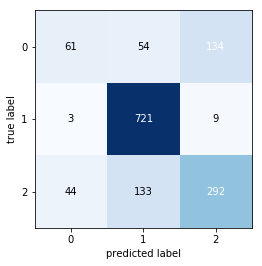

mnb : 0.7195037904893177

Classification Report:                precision    recall  f1-score   support

           0       0.44      0.05      0.09       249
           1       0.79      0.96      0.87       733
           2       0.61      0.69      0.65       469

   micro avg       0.72      0.72      0.72      1451
   macro avg       0.62      0.57      0.54      1451
weighted avg       0.67      0.72      0.66      1451




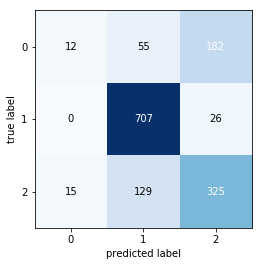

rfc : 0.7601654031702274

Classification Report:                precision    recall  f1-score   support

           0       0.51      0.38      0.43       249
           1       0.86      0.96      0.91       733
           2       0.67      0.65      0.66       469

   micro avg       0.76      0.76      0.76      1451
   macro avg       0.68      0.66      0.67      1451
weighted avg       0.74      0.76      0.75      1451




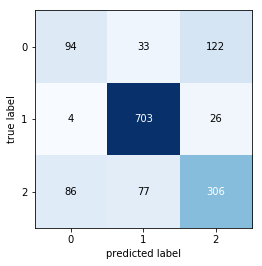

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
%matplotlib inline
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
#recall_score, precision_score, classification_report, f1_score

from sklearn.metrics import precision_recall_fscore_support as score

clfs = {
        'lr': LogisticRegression(), 
        'mnb': MultinomialNB(), 
        'rfc': RandomForestClassifier(), 
        'svm': SVC(kernel = 'linear', probability = True),
        'KNearest' :  KNeighborsClassifier(2),
        'DecisionTree' :  DecisionTreeClassifier(max_depth=5),
        'AdaBoost Classifier': AdaBoostClassifier(),
        'MLP' :  MLPClassifier(alpha=1, max_iter=1000)
       }

def test_clf(clf_dict, Xtrain, ytrain):
    for clf_name, clf in clf_dict.items():
        clf.fit(Xtrain, ytrain)
        predicted = clf.predict(X_test)
        print(clf_name,":",np.mean(predicted == y_test))
        print()
        print("Classification Report: ",classification_report(y_test, predicted))
        print() 
        cm = confusion_matrix(y_test, predicted)
        fig, ax = plot_confusion_matrix(conf_mat = cm)
        plt.show()
        
        
        precision, recall, fscore, support = score(y_test, predicted,average='weighted')



        #print("Accuracy: ",accuracy_score(y_test, predicted))
        #print('precision: {}'.format(precision))
        #print('recall: {}'.format(recall))
        #print('fscore: {}'.format(fscore))
        #print('support: {}'.format(support))
        
test_clf(clfs, X_train, y_train)

In [29]:



model = SVC(kernel = 'linear', probability = True).fit(X_train, y_train)
predicted = model.predict(X_test)
print(np.mean(predicted == y_test))
print(confusion_matrix(y_test, predicted))  

0.7732598208132323
[[ 75  29 145]
 [  3 716  14]
 [ 61  77 331]]


In [30]:

report= classification_report(y_test, predicted)
print(report)

              precision    recall  f1-score   support

           0       0.54      0.30      0.39       249
           1       0.87      0.98      0.92       733
           2       0.68      0.71      0.69       469

    accuracy                           0.77      1451
   macro avg       0.70      0.66      0.67      1451
weighted avg       0.75      0.77      0.75      1451



In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

scores_rfc = cross_val_score(SVC(kernel = 'linear', probability = True),  X_train, y_train, cv = 5, scoring = 'accuracy')
print(scores_rfc)
print(np.mean(scores_rfc))

[0.78300804 0.77909648 0.77747989 0.78245883 0.78399081]
0.7812068086900595


So the classification would be 50% accurate if the most frequent class was always chosen as the prediction.

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer01 = TfidfVectorizer()
X = vectorizer.transform(text)
#X = vectorizer01.fit_transform(text)
y = hate_speech_subset['Numeric_Verdict'].values
X_train, X_test, y_train, y_test = train_test_split(X, y)
print(X.shape)

(14509, 17138)


Thats a pretty big sparse matrix. Unfortunately dimensionality reduction isn't an option due to its structure.

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

clfs = {'lr': LogisticRegression(), 
        'mnb': MultinomialNB(), 
        'rfc': RandomForestClassifier(), 
        'svm': SVC(kernel = 'linear', probability = True),
        'KNearest' :  KNeighborsClassifier(2),
        'DecisionTree' :  DecisionTreeClassifier(max_depth=5),
        'AdaBoost Classifier': AdaBoostClassifier(),
        'MLP' :  MLPClassifier(alpha=1, max_iter=1000)}

def test_clf(clf_dict, Xtrain, ytrain):
    for clf_name, clf in clf_dict.items():
        clf.fit(Xtrain, ytrain)
        print(clf_name,':', clf.score(Xtrain, ytrain))
        
test_clf(clfs, X_train, y_train)

lr : 0.911956621634041
mnb : 0.8576417608675673
rfc : 0.9620439297858653
svm : 0.9461446558220752


MemoryError: 

The classifiers do pretty well with the Random Forest Classifier and the SVC with a linear kernel being the best. (I tried other kernels for the SVC and they didn't perform well.) These also have the most parameters to tune, so I'll stick with them in a bid to get even higher accuracy. Before I move on though, I want to look at the accuracy in a more nuanced way with the SVM.

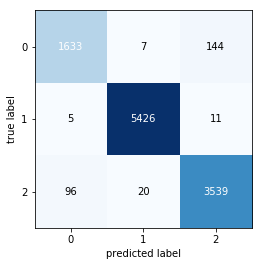

In [38]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
%matplotlib inline

cm = confusion_matrix(y_train, 
                      SVC(kernel = 'linear', probability = True).fit(X_train, y_train).predict(X_train))
fig, ax = plot_confusion_matrix(conf_mat = cm)
plt.show()

#0 : The tweet contains hate speech
#1 : The tweet is not offensive
#2 : The tweet uses offensive language but not hate speech

It's incredibly good at classifying non-offensive tweets, but less so with the category of utmost importance, hate speech. This is where the concepts of precision and recall enter the frame. The former is a measure of how well the classifier doesn't mislabel a class will recall measures how well it gets every label for the class. For those tweets that contain hate speech, the precision is around 93% while the recall is about 92%.

In this case, the most pertinent metric comes down to what is more important: making sure that tweets without hate speech aren't misclassified or getting as much instances of hate speech being used as possible. It's a trade-off as concentrating on one negatively affects the other. 

For now I'm going to use the F1 score which is a combination of precision and recall. It also is about the same as the accuracy in this case.

In [39]:
from sklearn.metrics import f1_score
f1_score(y_train,
         SVC(kernel = 'linear', probability = True).fit(X_train, y_train).predict(X_train), average='micro')

0.9739913610881353

Hyperparameter tuning of the SVC is long. My setup is below. The cross validation ran to completion and did badly on average. I had to stop the grid search lest it continue until the end of time.

In [40]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(SVC(kernel = 'linear', probability = True), X_train, y_train, cv = 10, scoring = 'accuracy')
print(scores)
print(np.mean(scores))

KeyboardInterrupt: 

In [ ]:
from sklearn.model_selection import GridSearchCV

C_range = np.logspace(-2, 4, 5)
gamma_range = np.logspace(-3, 3, 5)
param_grid = dict(gamma = gamma_range, C = C_range)
grid_svc = GridSearchCV(SVC(kernel = 'linear', probability = True), 
                        param_grid = param_grid, 
                        cv = 10, 
                        scoring = 'accuracy')
grid_svc.fit(X_train, y_train)
grid_svc.score(X_train, y_train)

Using cross validation with the Random Forest Classifier works much better.

In [ ]:
from sklearn.cross_validation import cross_val_score
scores_rfc = cross_val_score(RandomForestClassifier(), X_train, y_train, cv = 10, scoring = 'accuracy')
print(scores_rfc)
print(np.mean(scores_rfc))

It is clearly the better of the two models. The next step would be to do grid search to make the model even better, but that's something I have to return to. For now here's the skeleton.

In [ ]:
from sklearn.grid_search import GridSearchCV

param_grid = {"max_depth": [3, None],
              "n_estimators": [10, 50, 100]
              "max_features": [1, 3, 10],
              "min_samples_split": [1, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

grid_svc = GridSearchCV(RandomForestClassifier(), 
                        param_grid = param_grid, 
                        cv = 10, 
                        scoring = 'accuracy')
grid_svc.fit(X_train, y_train)
grid_svc.score(X_train, y_train)

Even though it hasn't been optimized, I'm going to built an app to classify hate speech with this model. To end, let export the pickle objects I'll need for the app, and look at how the model performs on the test set and on a constructed tweet.

In [ ]:
import pickle 

pickle.dump(clf_rfc, open('classifier.pkl', 'wb'), protocol = 4)
pickle.dump(stopwords.words('english'), open('stopwords.pkl', 'wb'), protocol = 4)
pickle.dump(vectorizer, open('vectorizer.pkl', 'wb'), protocol = 4)

In [ ]:
clf_rfc = RandomForestClassifier()
clf_rfc.fit(X_train, y_train)
clf_rfc.score(X_test, y_test)

In [ ]:
def classify_tweet(tweet, clf):
    tweet_to_clf = processTweet(tweet)
    tweet_to_clf = vectorizer.transform([tweet_to_clf])
    label = clf.predict(tweet_to_clf)[0]
    confidence = max(clf.predict_proba(tweet_to_clf)[0])*100
    return 'The model says: ' + le.inverse_transform(label) + ' with ' + str(round(confidence, 2)) + '% confidence.'

tweet = 'I hate you all.'
classify_tweet(tweet, clf_rfc)

I suppose it's right. 